In [5]:
import pandas as pd

# Load your Excel file
xls = pd.ExcelFile("CapEx.xlsx")

# Loop through all sheets and save as CSV
for sheet_name in xls.sheet_names:
    df = xls.parse(sheet_name)
    df.to_csv(f"{sheet_name.replace(' ', '_')}.csv", index=False)
    print(f"Saved {sheet_name} as {sheet_name.replace(' ', '_')}.csv")


Saved Electricity_vs_OPEX_LCOH as Electricity_vs_OPEX_LCOH.csv
Saved Press_vs_LCOH as Press_vs_LCOH.csv
Saved Temp_vs_LCOH as Temp_vs_LCOH.csv
Saved CapEx_vs_Year as CapEx_vs_Year.csv
Saved LCOH_vs_Year as LCOH_vs_Year.csv



Processing CapEx_vs_Year.csv
Model saved as models/gbr_model_capex_vs_year.pkl
Analysis for CapEx_vs_Year.csv:
Mean Squared Error (MSE): 61904434944.58934
R² Score: 0.9528109197642997



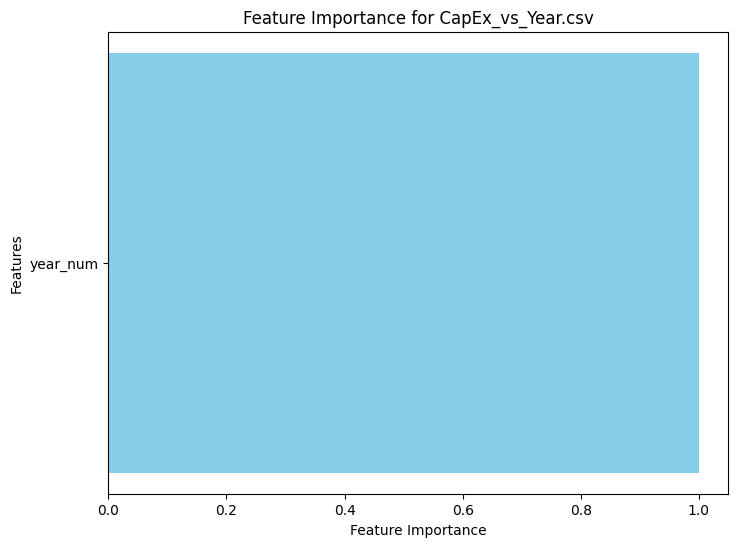

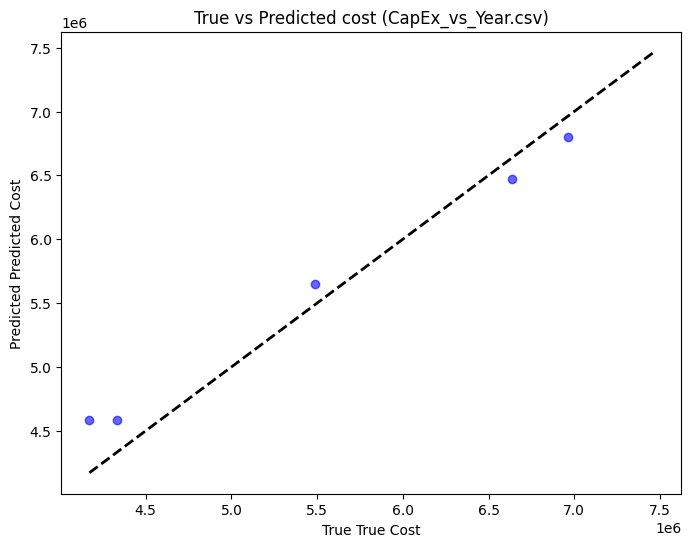

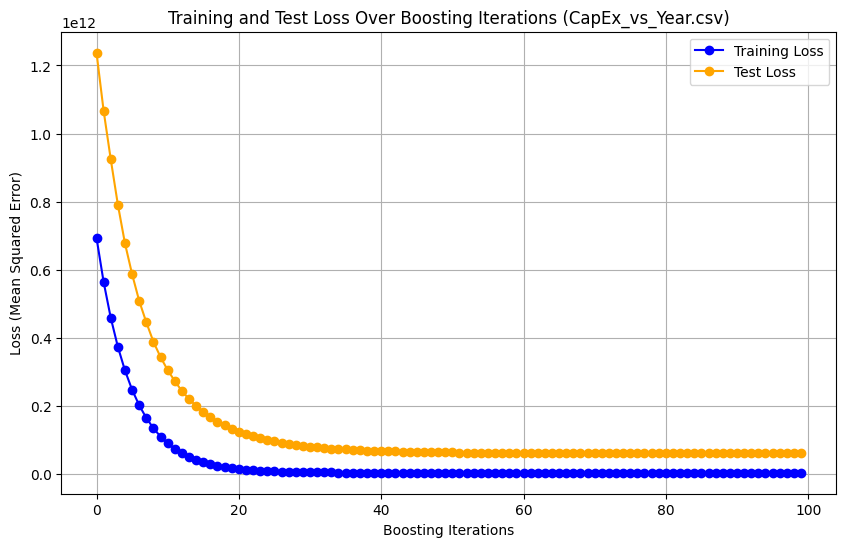


Processing LCOH_vs_Year.csv
Model saved as models/gbr_model_lcoh_vs_year.pkl
Analysis for LCOH_vs_Year.csv:
Mean Squared Error (MSE): 45.51784362687222
R² Score: 0.953236488663552



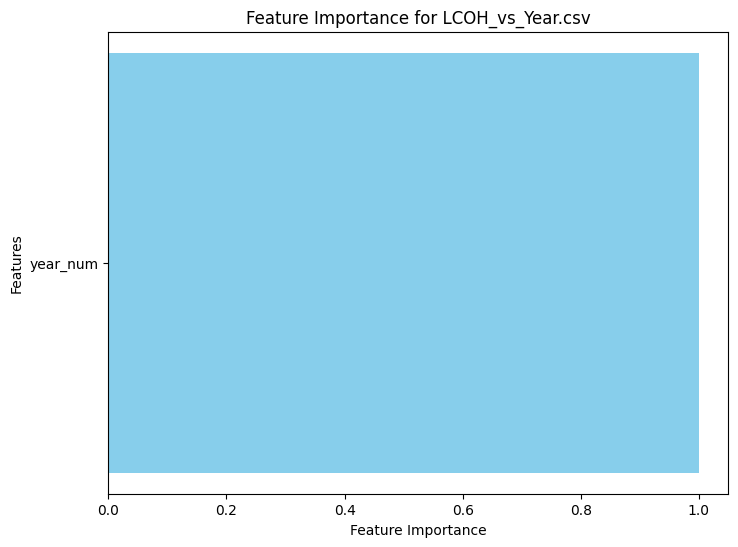

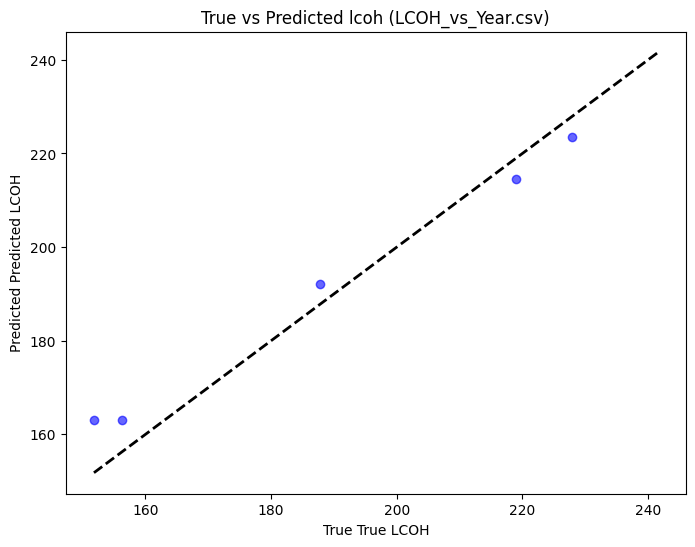

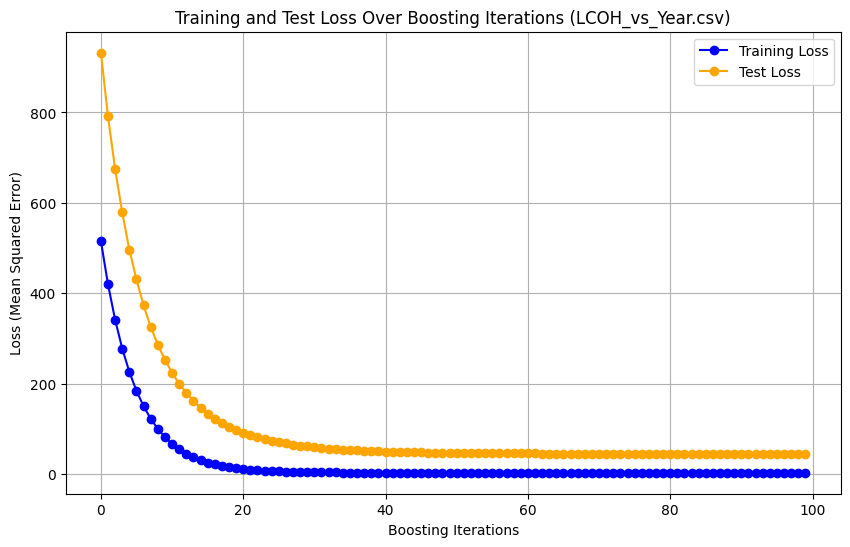


Processing Electricity_vs_OPEX_LCOH.csv
Model saved as models/gbr_model_electricity_vs_opex_lcoh.pkl
Analysis for Electricity_vs_OPEX_LCOH.csv:
Mean Squared Error (MSE): 0.01716239920650981
R² Score: 0.9990545827208109



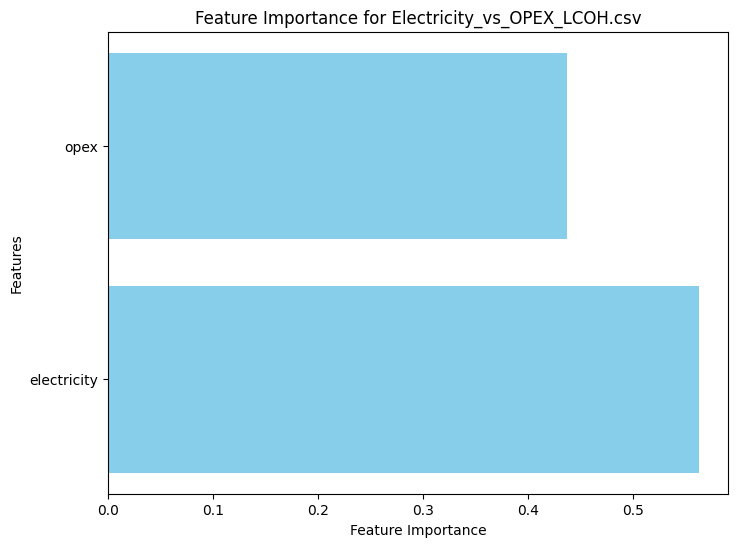

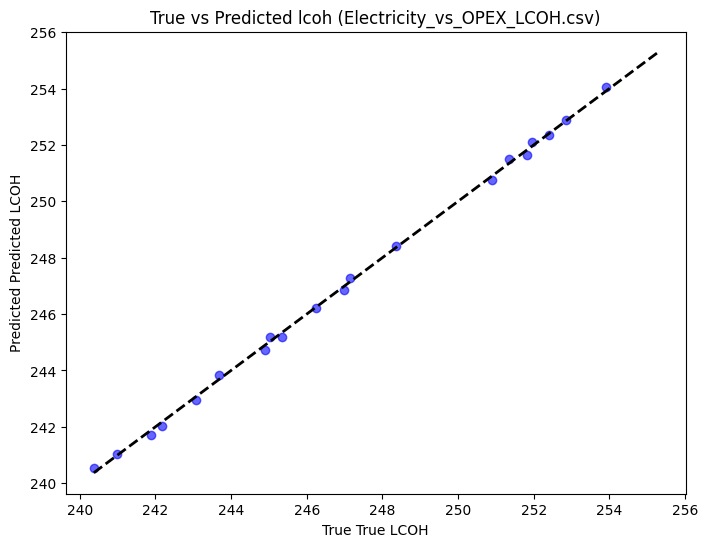

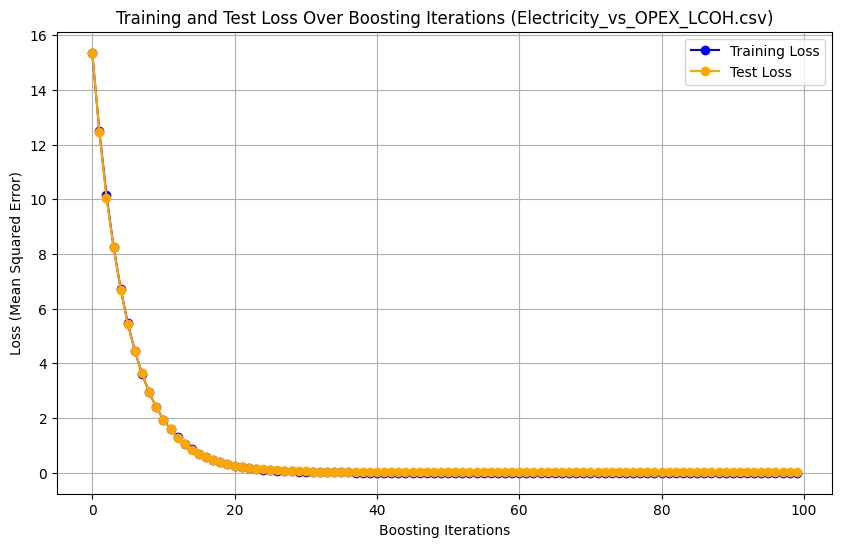


Processing Press_vs_LCOH.csv
Model saved as models/gbr_model_press_vs_lcoh.pkl
Analysis for Press_vs_LCOH.csv:
Mean Squared Error (MSE): 3.832781290183776e-10
R² Score: 0.9999328961021132



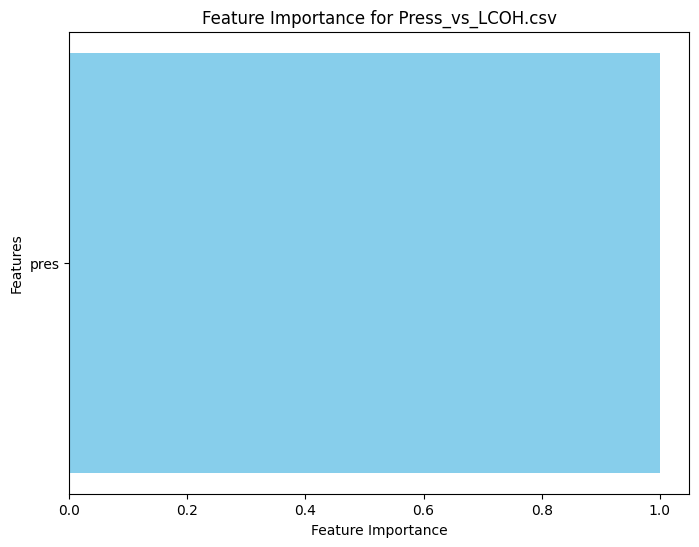

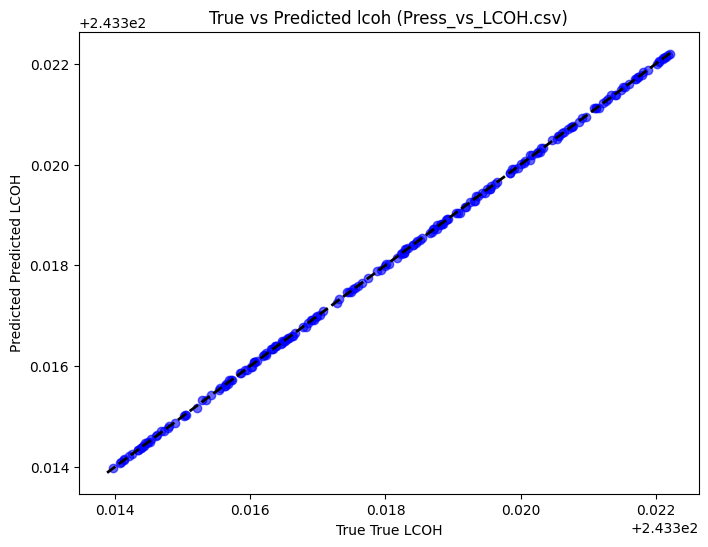

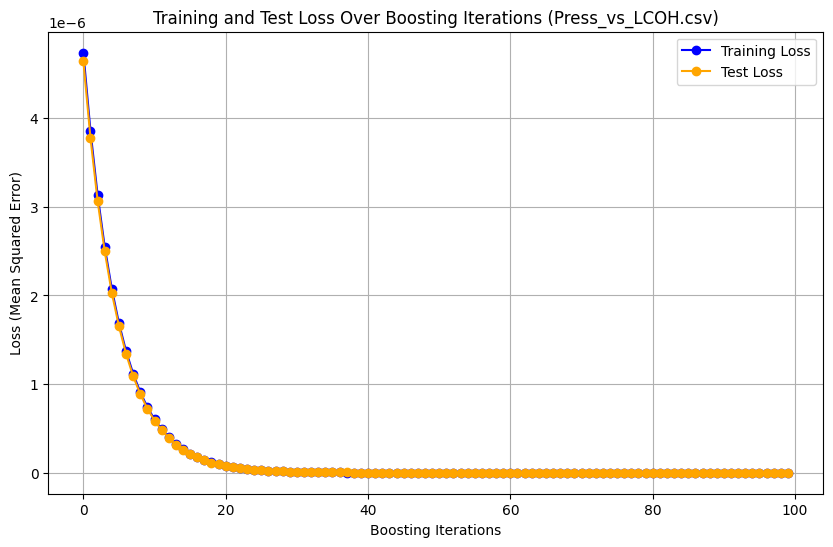


Processing Temp_vs_LCOH.csv
Model saved as models/gbr_model_temp_vs_lcoh.pkl
Analysis for Temp_vs_LCOH.csv:
Mean Squared Error (MSE): 1.5582963254915174e-05
R² Score: 0.9999285629979275



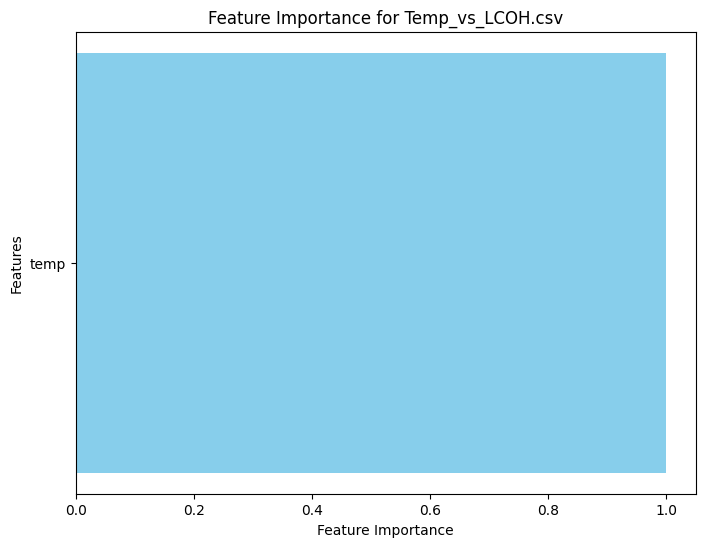

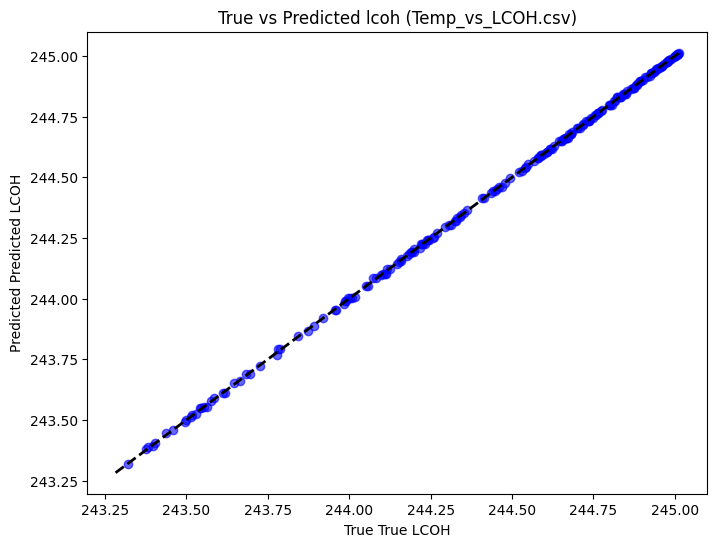

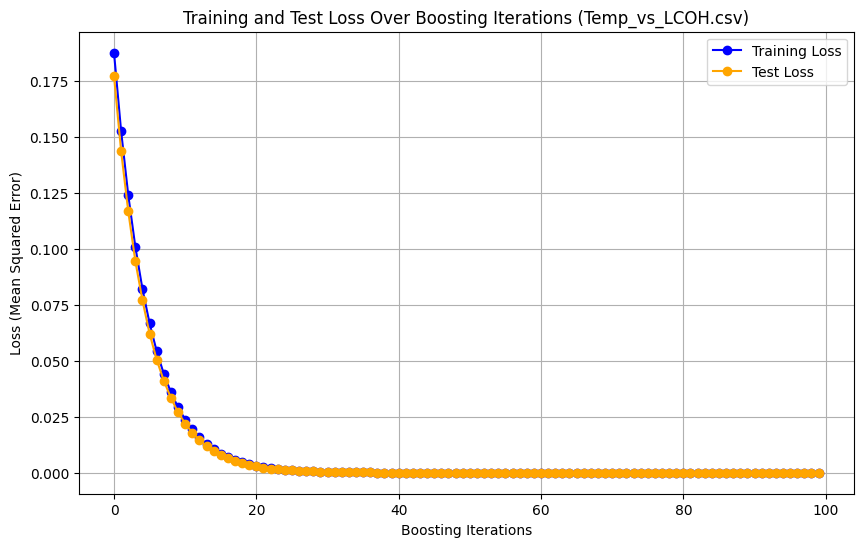

In [10]:
# Importing necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pickle

# Enable inline plotting for Jupyter Notebook
%matplotlib inline

# Function to load data, train GBR model, and evaluate results
def analyze_gbr(data_path, features, target, x_label=None, y_label=None):
    # Load data
    data = pd.read_csv(data_path)
    print(f"\nProcessing {data_path}")
    
    # Handle date columns if present
    if 'YEAR' in data.columns:
        data['year_num'] = pd.to_datetime(data['YEAR']).dt.year
    elif 'Date' in data.columns:
        data['year_num'] = pd.to_datetime(data['Date']).dt.year
    
    # Clean column names
    data.columns = [col.strip().lower().replace(" ", "_").replace("(", "").replace(")", "")
                   .replace("₂", "2").replace("ₓ", "x").replace("/", "_per_") 
                   for col in data.columns]
    
    if 'lcoh_usd_per_kg_h2' in data.columns:
        data = data.rename(columns={'lcoh_usd_per_kg_h2': 'lcoh'})
    
    # Split data into features (X) and target (y)
    X = data[features]
    y = data[target]
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize and train Gradient Boosting Regressor
    gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    gbr.fit(X_train, y_train)
    
    # Create and save model
    model_filename = f"models/gbr_model_{data_path.split('.')[0].lower()}.pkl"
    with open(model_filename, 'wb') as file:
        pickle.dump(gbr, file)
    print(f"Model saved as {model_filename}")
    
    # Make predictions
    y_pred = gbr.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Analysis for {data_path}:")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"R² Score: {r2}\n")
    
    # Feature importance visualization
    feature_importance = gbr.feature_importances_
    plt.figure(figsize=(8, 6))
    plt.barh(features, feature_importance, color='skyblue')
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    plt.title(f'Feature Importance for {data_path}')
    plt.show()
    
    # True vs Predicted Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    plt.xlabel(f'True {x_label if x_label else target}')
    plt.ylabel(f'Predicted {y_label if y_label else target}')
    plt.title(f'True vs Predicted {target} ({data_path})')
    plt.show()
    
    # Compute and plot training and test loss
    train_loss = []
    test_loss = []
    
    for y_train_pred, y_test_pred in zip(gbr.staged_predict(X_train), gbr.staged_predict(X_test)):
        train_loss.append(mean_squared_error(y_train, y_train_pred))
        test_loss.append(mean_squared_error(y_test, y_test_pred))
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label='Training Loss', color='blue', marker='o')
    plt.plot(test_loss, label='Test Loss', color='orange', marker='o')
    plt.xlabel('Boosting Iterations')
    plt.ylabel('Loss (Mean Squared Error)')
    plt.title(f'Training and Test Loss Over Boosting Iterations ({data_path})')
    plt.legend()
    plt.grid(True)
    plt.show()

# Define the datasets and their configurations
datasets = {
    "CapEx_vs_Year.csv": {
        "features": ["year_num"],
        "target": "cost",
        "x_label": "True Cost",
        "y_label": "Predicted Cost"
    },
    "LCOH_vs_Year.csv": {
        "features": ["year_num"],
        "target": "lcoh",
        "x_label": "True LCOH",
        "y_label": "Predicted LCOH"
    },
    "Electricity_vs_OPEX_LCOH.csv": {
        "features": ["electricity", "opex"],
        "target": "lcoh",
        "x_label": "True LCOH",
        "y_label": "Predicted LCOH"
    },
    "Press_vs_LCOH.csv": {
        "features": ["pres"],
        "target": "lcoh",
        "x_label": "True LCOH",
        "y_label": "Predicted LCOH"
    },
    "Temp_vs_LCOH.csv": {
        "features": ["temp"],
        "target": "lcoh",
        "x_label": "True LCOH",
        "y_label": "Predicted LCOH"
    }
}

# Create models directory if it doesn't exist
import os
os.makedirs("models", exist_ok=True)

# Perform analysis for each dataset
for file, config in datasets.items():
    try:
        analyze_gbr(
            data_path=file,
            features=config["features"],
            target=config["target"],
            x_label=config.get("x_label"),
            y_label=config.get("y_label")
        )
    except Exception as e:
        print(f"Error processing {file}: {str(e)}")